In [1]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar

In [2]:
dataset = np.load("/home/roberts/O-PPAC/recomplied_dataset.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(991, 342, 132)


In [3]:
x_peaks = np.load("x_peaks_data_ALL.npy")
y_peaks = np.load("y_peaks_data_ALL.npy")
error_indices = np.load("error_indices.npy")

gaussian = np.vstack((x_peaks,y_peaks)) #define new, single variable for x and y gaussian peaks
gaussian = np.transpose(gaussian) #original definition was sideways, so we transposed it
print(gaussian.shape)

(318628, 2)


In [5]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [6]:
#define all_labels and all_data as df's to better view rows and add column
all_labels = pd.DataFrame(all_labels)
all_data = pd.DataFrame(all_data)
all_data["sum"] = np.sum(all_data, axis = 1) #column added to find rows with only 0's
all_gauss = pd.DataFrame(gaussian)

#confirming number of initial entries
print(len(all_labels))
print(len(all_data))
print(len(all_gauss))
print(len(error_indices))


fixed_labels = all_labels.drop(all_labels.index[error_indices])
fixed_data = all_data.drop(all_data.index[error_indices])


#find all the locations in all_data (by index) where the only values are 0 across the diodes
remove_labels = list(fixed_data[fixed_data["sum"] == 0].index)
print(len(remove_labels))

#added these to ensure I have unshuffled versions of the data and labels for finding locations with larger error
unshuf_labels = fixed_labels.drop(fixed_labels.index[remove_labels])
unshuf_gauss = all_gauss.drop(all_gauss.index[remove_labels])
unshuf_data = fixed_data[fixed_data["sum"] != 0]

#lets all_labels and all_data start with the same indices and values as their unshuffled counterparts
all_labels = unshuf_labels
unshuf_labels = unshuf_labels.to_numpy() #dfs are hard to graph with, so I converted to np.arrays for future use
all_data = unshuf_data
unshuf_data = unshuf_data.to_numpy()
all_gauss = unshuf_gauss
unshuf_gauss = unshuf_gauss.to_numpy()

#confirm new number of entries (should be len(remove_labels) less than the intital value)
print(len(all_labels))
print(len(all_data))
print(len(all_gauss))

#must remove the sum column before using in FCNN; otherwise it will treat it as a data point 
del all_data['sum']

338922
338922
318628
20294
286
318342
318342
318342


In [7]:
train_data, test_data, train_labels, test_labels, train_gauss, test_gauss = train_test_split(all_data, all_labels, all_gauss, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [8]:
test_data.to_pickle("test_data_df_5")
test_labels.to_pickle("test_labels_df_5")

#df = pd.read_pickle(file_name)
#to read back in

In [9]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [10]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [11]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [12]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=120,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/120
5571/5571 [==============================] - 19s 3ms/step - loss: 4.8110 - mae: 0.7265 - mse: 4.8110 - val_loss: 0.4640 - val_mae: 0.4442 - val_mse: 0.4640
Epoch 2/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.3991 - mae: 0.3765 - mse: 0.3991 - val_loss: 0.3033 - val_mae: 0.3108 - val_mse: 0.3033
Epoch 3/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.3157 - mae: 0.3048 - mse: 0.3157 - val_loss: 0.2723 - val_mae: 0.2651 - val_mse: 0.2723
Epoch 4/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.2841 - mae: 0.2682 - mse: 0.2841 - val_loss: 0.2436 - val_mae: 0.2468 - val_mse: 0.2436
Epoch 5/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.2624 - mae: 0.2430 - mse: 0.2624 - val_loss: 0.2134 - val_mae: 0.2008 - val_mse: 0.2134
Epoch 6/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.2465 - mae: 0.2245 - mse: 0.2465 - val_loss: 0.2206 - val_mae: 0.2127 - val_mse:

5571/5571 [==============================] - 18s 3ms/step - loss: 0.1654 - mae: 0.0802 - mse: 0.1654 - val_loss: 0.1906 - val_mae: 0.0764 - val_mse: 0.1906
Epoch 98/120
5571/5571 [==============================] - 19s 3ms/step - loss: 0.1657 - mae: 0.0811 - mse: 0.1657 - val_loss: 0.1794 - val_mae: 0.0751 - val_mse: 0.1794
Epoch 99/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.1605 - mae: 0.0796 - mse: 0.1605 - val_loss: 0.1852 - val_mae: 0.0856 - val_mse: 0.1852
Epoch 100/120
5571/5571 [==============================] - 19s 3ms/step - loss: 0.1629 - mae: 0.0783 - mse: 0.1629 - val_loss: 0.1779 - val_mae: 0.0654 - val_mse: 0.1779
Epoch 101/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.1631 - mae: 0.0791 - mse: 0.1631 - val_loss: 0.1856 - val_mae: 0.0725 - val_mse: 0.1856
Epoch 102/120
5571/5571 [==============================] - 18s 3ms/step - loss: 0.1657 - mae: 0.0789 - mse: 0.1657 - val_loss: 0.1768 - val_mae: 0.0872 - val_mse: 0.1

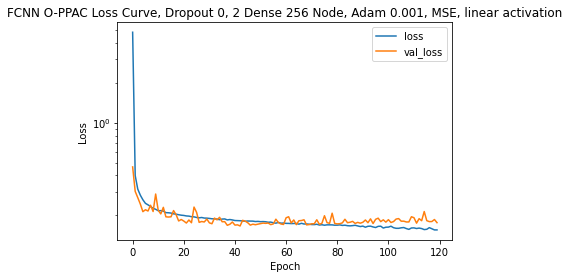

1990/1990 - 3s - loss: 0.1706 - mae: 0.0809 - mse: 0.1706


In [13]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [14]:
#separates x and y predicted values so there can be separate graphs for each
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = test_labels[0]
y_test1 = test_labels[1]

#converts to np.arrays for graphing
x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test[0]
y_test[0]

-20.0

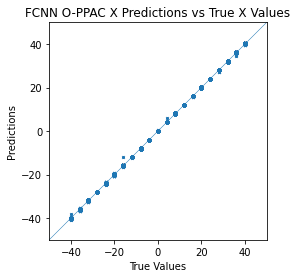

In [15]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

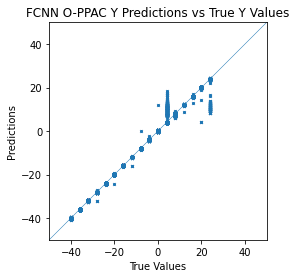

In [16]:
#graph showing the accuracy of FCNN model by comparing predicted and true y values
#should be as close to the diagonal as possible
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [17]:
#to find the locations of largest error within my predicted x values
x_error = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)

4
[4.053986549377441, 1.9520530700683594, 1.8718624114990234, -1.4884414672851562]


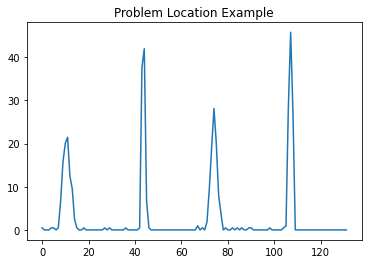

[29]


In [20]:
#graph the location of areas with larger x-error; uses unshuffled data from above
bad_xvalue = xerror_list[0]
x_test_locat = x_error.index(bad_xvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[x_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_xvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_xvalue)])))

print(np.intersect1d(x_locat, y_locat))

In [21]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

321
[14.44863510131836, 13.615325927734375, 13.002134323120117, 12.75480842590332, 12.704111099243164, 12.016828536987305, 11.862890243530273, 10.81825065612793, 10.466018676757812, 10.372166633605957, 9.836908340454102, 9.680830001831055, 9.654082298278809, 9.602224349975586, 9.559992790222168, 9.489835739135742, 9.459471702575684, 9.127324104309082, 8.957074165344238, 8.932321548461914, 8.891751289367676, 8.873454093933105, 8.826915740966797, 8.738936424255371, 8.612953186035156, 8.422574996948242, 8.290730476379395, 8.280318260192871, 8.265069961547852, 8.246209144592285, 8.243526458740234, 8.22844409942627, 8.205721855163574, 8.159031867980957, 8.094779014587402, 8.086282730102539, 8.0534029006958, 8.038837432861328, 8.019079208374023, 8.00909423828125, 8.002976924180984, 7.979036331176758, 7.925345420837402, 7.920502662658691, 7.917137145996094, 7.88422966003418, 7.865884780883789, 7.8288164138793945, 7.68092155456543, 7.596673011779785, 7.539760589599609, 7.5354814529418945, 7.52

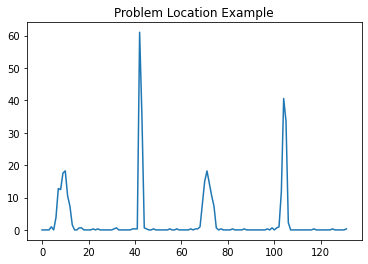

[47]


In [22]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue = yerror_list[0]
y_test_locat = y_error.index(bad_yvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[y_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_yvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_yvalue)])))

print(np.intersect1d(x_locat, y_locat))

63669


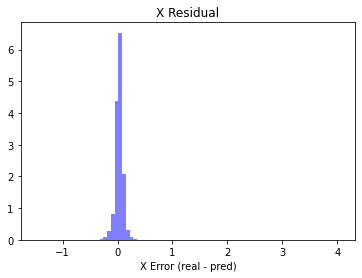

In [24]:
#residue plot of x-error from the FCNN model
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if abs(i) <= 10]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()

63595


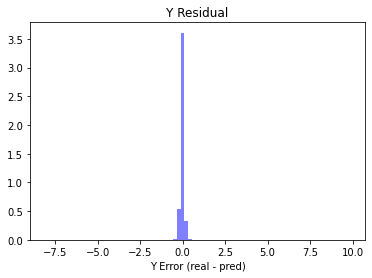

In [25]:
#residue plot of y-error from the FCNN model
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

error_list_y = [i for i in y_error if abs(i) <= 10]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')
plt.title(r'Y Residual')
plt.show()

In [ ]:
#gaussian vs test labels

In [26]:
x_gauss_test = test_gauss[0]
y_gauss_test = test_gauss[1]

print(x_gauss_test.shape)
print(y_gauss_test.shape)

(63669,)
(63669,)


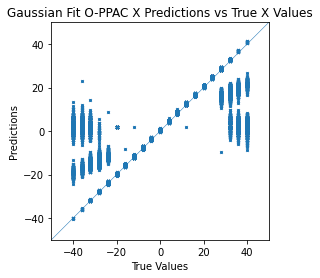

In [27]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_gauss_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X Predictions vs True X Values")
plt.show()

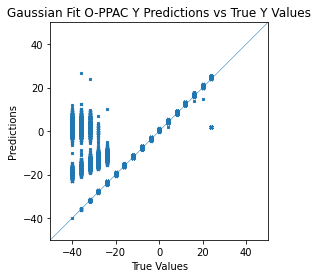

In [28]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_y_labels, y_gauss_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC Y Predictions vs True Y Values")
plt.show()

In [35]:
print(y_test.shape)
print(y_gauss_test.shape)

print(type(y_test))
print(type(y_gauss_test))

y_gauss = y_gauss_test.to_numpy()

(63669,)
(63669,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [36]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error_g = []

for i in range(y_gauss.shape[0]):
    y_error_test_g = y_gauss[i] - y_test[i]
    y_error_g.append(y_error_test_g)

yerror_list_g = [i for i in y_error_g if abs(i) >= 1]
yerror_list_g.sort(reverse = True)
print(len(yerror_list_g))
print(yerror_list_g)

16685
[62.781230316041785, 55.9692335765549, 51.99754809324385, 50.41040355733187, 50.33041354056666, 49.57367414497418, 49.55710938516074, 49.48228907936711, 49.1246923560103, 48.94098055890486, 48.81828943574948, 48.81817933826746, 48.81816142779188, 48.81789375780251, 48.793795607173216, 48.784766193550894, 48.606151361494675, 48.53778269535007, 48.478991040271204, 48.36645841461665, 48.211248953612284, 48.12091200469258, 48.0614240788325, 48.06063925901756, 48.060606568933316, 48.06059242522131, 48.060591998886, 48.060562576735066, 48.059781960505205, 48.05978160382497, 48.05470825201976, 48.05460890674869, 48.035404681486014, 48.03122058590001, 48.018335334338154, 48.016455094661396, 47.488502150190456, 47.335906646705844, 47.31434640182782, 47.3121230753709, 47.30456277579858, 47.30319831447164, 47.30318658669334, 47.30303783034712, 47.303030337165936, 47.30302902268023, 47.30302673923402, 47.3030264134748, 47.30302489075816, 47.30302469605044, 47.3030229602534, 47.30301762039842

5.030293615883508
-40.0
8.0
27789


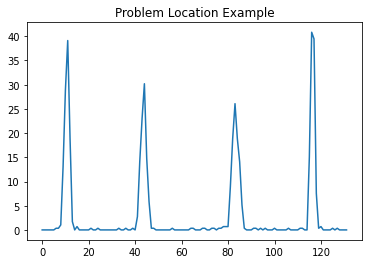

In [55]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue_g = yerror_list_g[234]
y_test_locat_g = y_error_g.index(bad_yvalue_g)

print(y_gauss[y_test_locat_g])
print(y_test[y_test_locat_g])
print(x_test[y_test_locat_g])
print(y_test_locat_g)

plt.title('Problem Location Example')
plt.plot(unshuf_data[y_test_locat_g][:-1]*100)
plt.show()

In [46]:
print(bad_yvalue_g)

44.2724903397546


In [49]:
print(unshuf_data.shape)

(318342, 133)


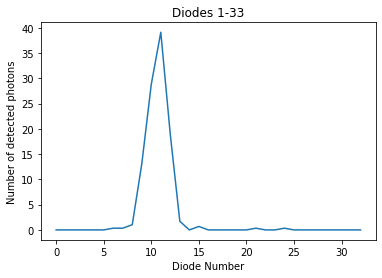

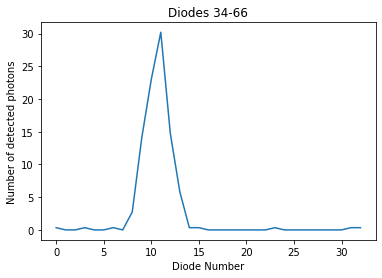

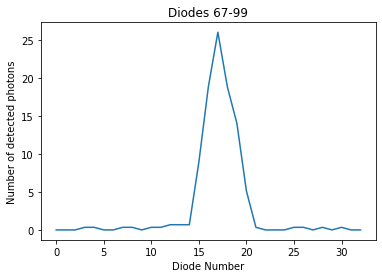

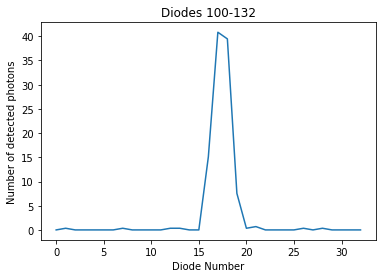

In [54]:
test_histogram1 = []
for i in range(33):
    test_histogram1.append(unshuf_data[y_test_locat_g][i]*100)   
np.array(test_histogram1)

plt.title('Diodes 1-33')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
#plt.axis([-1, 33, -5, 350])
plt.plot(test_histogram1)
#plt.axvline(x = x_peak_value, color = "magenta", linewidth=1, linestyle='dashdot')
plt.show()

test_histogram2 = []
for i in range(33,66):
    test_histogram2.append(unshuf_data[y_test_locat_g][i]*100)     
np.array(test_histogram2)

plt.title('Diodes 34-66')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
#plt.axis([-1, 33, -5, 350])
plt.plot(test_histogram2)
#plt.axvline(x = x_peak_value, color = "magenta", linewidth=1, linestyle='dashdot')
plt.show()

test_histogram3 = []
for i in range(66,99):
    test_histogram3.append(unshuf_data[y_test_locat_g][i]*100)     
np.array(test_histogram3)

plt.title('Diodes 67-99')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
#plt.axis([-1, 33, -5, 350])
plt.plot(test_histogram3)
#plt.axvline(x = y_peak_value, color = "magenta", linewidth=1, linestyle='dashdot')
plt.show()

test_histogram4 = []
for i in range(99,132):
    test_histogram4.append(unshuf_data[y_test_locat_g][i]*100)    
np.array(test_histogram4)

plt.title('Diodes 100-132')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
#plt.axis([-1, 33, -5, 350])
plt.plot(test_histogram4)
#plt.axvline(x = y_peak_value, color = "magenta", linewidth=1, linestyle='dashdot') 
plt.show()